In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks

In [8]:
# Water pump sensor data (via Kaggle datasets)
selected_fp = 'data/Pump Sensors/sensor.csv'
df_raw = pd.read_csv(selected_fp, sep = ",")
df_raw['timestamp'].head(3)

0    2018-04-01 00:00:00
1    2018-04-01 00:01:00
2    2018-04-01 00:02:00
Name: timestamp, dtype: object

In [9]:
df_raw.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [10]:
# Convert timestamp to datetime datatype & sort
df_raw = df_raw.drop('Unnamed: 0', axis = 1)\
  .assign(timestamp = lambda x: pd.to_datetime(x['timestamp'], format = '%Y-%m-%d %H:%M:%S'))\
  .sort_values(by = 'timestamp')

In [11]:
df_raw.head(2) 

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


In [12]:
# Assign the timestamp as index for easier plotting
df_raw.index = df_raw['timestamp']

In [13]:
# Check on machine status values
print('Reported status types: ', df_raw['machine_status'].unique())

Reported status types:  ['NORMAL' 'BROKEN' 'RECOVERING']


In [14]:
# Check raw data
pdm.check_for_nas(df_raw)

timestamp has 0 NAs			0.0%
sensor_00 has 10208 NAs			4.63%
sensor_01 has 369 NAs			0.17%
sensor_02 has 19 NAs			0.01%
sensor_03 has 19 NAs			0.01%
sensor_04 has 19 NAs			0.01%
sensor_05 has 19 NAs			0.01%
sensor_06 has 4798 NAs			2.18%
sensor_07 has 5451 NAs			2.47%
sensor_08 has 5107 NAs			2.32%
sensor_09 has 4595 NAs			2.09%
sensor_10 has 19 NAs			0.01%
sensor_11 has 19 NAs			0.01%
sensor_12 has 19 NAs			0.01%
sensor_13 has 19 NAs			0.01%
sensor_14 has 21 NAs			0.01%
sensor_15 has 220320 NAs			100.0%
sensor_16 has 31 NAs			0.01%
sensor_17 has 46 NAs			0.02%
sensor_18 has 46 NAs			0.02%
sensor_19 has 16 NAs			0.01%
sensor_20 has 16 NAs			0.01%
sensor_21 has 16 NAs			0.01%
sensor_22 has 41 NAs			0.02%
sensor_23 has 16 NAs			0.01%
sensor_24 has 16 NAs			0.01%
sensor_25 has 36 NAs			0.02%
sensor_26 has 20 NAs			0.01%
sensor_27 has 16 NAs			0.01%
sensor_28 has 16 NAs			0.01%
sensor_29 has 72 NAs			0.03%
sensor_30 has 261 NAs			0.12%
sensor_31 has 16 NAs			0.01%
sensor_32 has 68 NAs			0.03

sensor_15, 50 and 51 contain a large number of NAs, let's drop for initial assessment.

In [15]:
# Drop columns with high degress of missingness
df_set = df_raw.drop(['sensor_15', 'sensor_50', 'sensor_51'], axis = 1)

# Replace NAs in remaining data by using lasf value fill forward method
df_set = df_set.fillna(method = 'ffill')

In [16]:
# Check for NAs again (to verify fill NA has worked)
pdm.check_for_nas(df_set)

timestamp has 0 NAs			0.0%
sensor_00 has 0 NAs			0.0%
sensor_01 has 0 NAs			0.0%
sensor_02 has 0 NAs			0.0%
sensor_03 has 0 NAs			0.0%
sensor_04 has 0 NAs			0.0%
sensor_05 has 0 NAs			0.0%
sensor_06 has 0 NAs			0.0%
sensor_07 has 0 NAs			0.0%
sensor_08 has 0 NAs			0.0%
sensor_09 has 0 NAs			0.0%
sensor_10 has 0 NAs			0.0%
sensor_11 has 0 NAs			0.0%
sensor_12 has 0 NAs			0.0%
sensor_13 has 0 NAs			0.0%
sensor_14 has 0 NAs			0.0%
sensor_16 has 0 NAs			0.0%
sensor_17 has 0 NAs			0.0%
sensor_18 has 0 NAs			0.0%
sensor_19 has 0 NAs			0.0%
sensor_20 has 0 NAs			0.0%
sensor_21 has 0 NAs			0.0%
sensor_22 has 0 NAs			0.0%
sensor_23 has 0 NAs			0.0%
sensor_24 has 0 NAs			0.0%
sensor_25 has 0 NAs			0.0%
sensor_26 has 0 NAs			0.0%
sensor_27 has 0 NAs			0.0%
sensor_28 has 0 NAs			0.0%
sensor_29 has 0 NAs			0.0%
sensor_30 has 0 NAs			0.0%
sensor_31 has 0 NAs			0.0%
sensor_32 has 0 NAs			0.0%
sensor_33 has 0 NAs			0.0%
sensor_34 has 0 NAs			0.0%
sensor_35 has 0 NAs			0.0%
sensor_36 has 0 NAs			0.0%
s

In [17]:
# Apply some cleaning to df_set based on inspection of the timetrace signals
# S1 displays regular spikes without transition points, clamp these (replace with median)
# Any points less than 28,replace with median
s1_med = df_set['sensor_01'].median()
df_set['sensor_01'] = df_set['sensor_01']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 28, cl_val = s1_med, cl_type = 'low'))

s6_med = df_set['sensor_06'].median()
df_set['sensor_06'] = df_set['sensor_06']\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s6_med, cl_type = 'low'))\
  .apply(lambda x: s6_med if x in ['nan'] else pdm.clampit(x, cl_lim = 25, cl_val = s6_med, cl_type = 'high'))

# S9 similarly displays some regular spikes that we will assume are spurious
# Any points less than 6 or greater than 21,replace with median
s9_med = df_set['sensor_09'].median()
df_set['sensor_09'] = df_set['sensor_09']\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 6, cl_val = s9_med, cl_type = 'low'))\
  .apply(lambda x: s1_med if x in ['nan'] else pdm.clampit(x, cl_lim = 21, cl_val = s9_med, cl_type = 'high'))

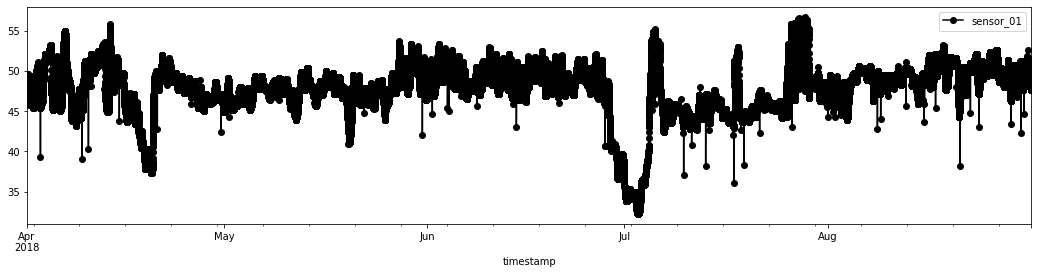

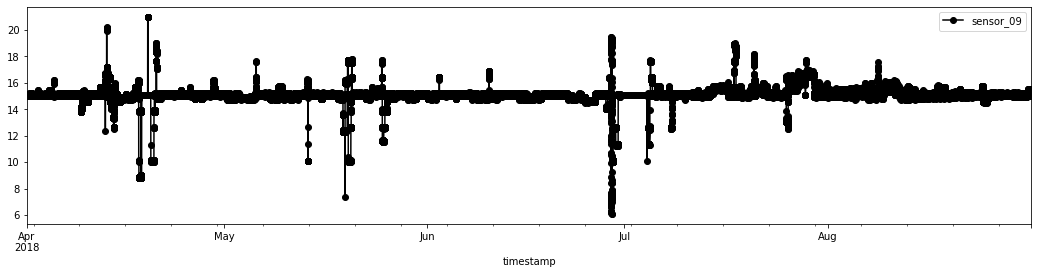

In [13]:
# Check the results of cleaning
cleaned_sensors = ['sensor_01', 'sensor_09']
for sen in cleaned_sensors:
    df_set[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [14]:
df_set.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'machine_status'],
      dtype='object')

In [18]:
include_cols = [
    'timestamp', 
    'sensor_00',
    'sensor_01',
    'sensor_02',
    'sensor_03',
    'sensor_04',
    'sensor_05',
    'sensor_06',
    'machine_status'
]

In [19]:
# Subset data tagged as 'Normal' operating 
df_norm = df_set.loc[df_set['machine_status'] == 'NORMAL', include_cols]  
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_reco = df_set.loc[df_set['machine_status'] == 'RECOVERING', include_cols] 
df_reco['timestamp'] = pd.to_datetime(df_reco.index, format = '%Y-%m-%d %H:%M:%S')

# Subset data tagged as 'Normal' operating 
df_brok = df_set.loc[df_set['machine_status'] == 'BROKEN', include_cols] 
df_brok['timestamp'] = pd.to_datetime(df_brok.index, format = '%Y-%m-%d %H:%M:%S')

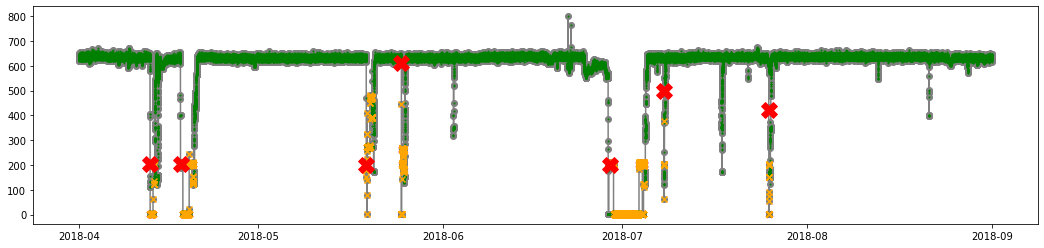

In [20]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set['sensor_04'], color = 'grey', marker = 'o', zorder = 1)
ax.scatter(df_norm['timestamp'], df_norm['sensor_04'], color ='green', marker = 'o', zorder = 2, s = 1)
ax.scatter(df_reco['timestamp'], df_reco['sensor_04'], color ='orange', marker = 'x', zorder = 3)
ax.scatter(df_brok['timestamp'], df_brok['sensor_04'], color ='red', marker = 'X', zorder = 3, s = 250)
plt.show()

Time series shows 7x recorded failures with recovery periods.  

### Data Scaling

In [21]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [22]:
# Scale the data (between 0 and 1)
df_num = df_set.drop(['timestamp', 'machine_status'], axis = 1)
scaler = preprocessing.MinMaxScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['timestamp'] = df_set['timestamp']
df_set_scaled['machine_status'] = df_set['machine_status']
df_set_scaled.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,0.894917,0.627723,0.774151,0.730507,0.737412,0.733950,0.478444,0.656802,0.610348,0.602086,...,0.092794,0.036376,0.037825,0.050506,0.017351,0.057022,0.063036,0.062032,0.232684,0.069667
std,0.229663,0.134402,0.160332,0.145899,0.180685,0.173011,0.063111,0.133608,0.121586,0.048387,...,0.043674,0.019772,0.029138,0.028752,0.011882,0.043666,0.045462,0.037788,0.153641,0.043728
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.949054,0.575221,0.753320,0.675392,0.782515,0.699763,0.454140,0.671980,0.621654,0.603005,...,0.070250,0.029335,0.030325,0.039322,0.011286,0.035433,0.041211,0.042932,0.107568,0.048249
50%,0.963335,0.649558,0.808349,0.759162,0.790064,0.755765,0.469279,0.685162,0.634146,0.604945,...,0.087813,0.035202,0.036982,0.048136,0.015147,0.047244,0.053827,0.054450,0.208649,0.059484
75%,0.980702,0.704425,0.857685,0.824607,0.796307,0.809119,0.525378,0.696199,0.644259,0.607368,...,0.111229,0.042373,0.042160,0.057627,0.019899,0.062992,0.072330,0.070157,0.340000,0.077991
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Remove periods when pump was broken or covering + transition window
trans_win = 1*24*60

# Create map to reduce categories to two
# We want to remove 'recovering' so combine it with 'broken'
condition_map = {
    'RECOVERING': 'BROKEN', 
    'NORMAL': 'NORMAL', 
    'BROKEN': 'BROKEN'
}

In [24]:
# Use besploke function from pdm_functions
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['machine_status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win,
    keep = 'NORMAL'
)

Input segement categories:  ['NORMAL' 'BROKEN' 'RECOVERING']
Categories after mapping:  ['NORMAL' 'BROKEN']
Run length encoding:  [('NORMAL', 17155), ('BROKEN', 945), ('NORMAL', 6410), ('BROKEN', 3111), ('NORMAL', 41697), ('BROKEN', 1313), ('NORMAL', 7159), ('BROKEN', 606), ('NORMAL', 49644), ('BROKEN', 8391), ('NORMAL', 4700), ('BROKEN', 42), ('NORMAL', 25267), ('BROKEN', 76), ('NORMAL', 53804)]
>
Skipping NORMAL segment(s)...
>
Remove rows:  [15715, 19539]
Removing 3825 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [23070, 29060]
Removing 5991 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [67878, 72070]
Removing 4193 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [76350, 79835]
Removing 3486 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [126600, 137870]
Removing 11271 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [139691, 142612]
Removing 2922 rows...
>
Skipping NORMAL segment(s)...
>
Remove rows:  [165000, 167955]
Removing 2956 rows..

In [25]:
# Quick check to confirm only one category 'normal' remains in the data
print('Remaining category:', df_norm['machine_status'].unique())
print('Remaining columns:', df_norm.columns)

Remaining category: ['NORMAL']
Remaining columns: Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'timestamp',
       'machine_status'],
      dtype='object')


In [26]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print('Nrows normal: ' + str(len(df_norm)) + ' (' + str(round(100*len(df_norm)/tot_rows)) + '%)')
print('Nrows abnorm: ' + str(len(df_abnorm)) + ' (' + str(round(100*len(df_abnorm)/tot_rows)) + '%)')

Nrows normal: 185676 (84%)
Nrows abnorm: 34644 (16%)


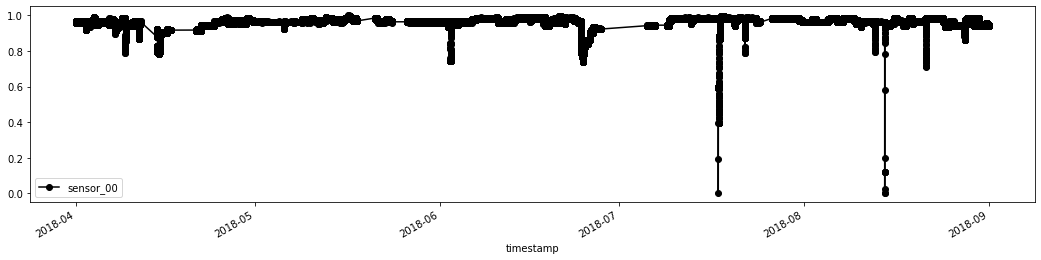

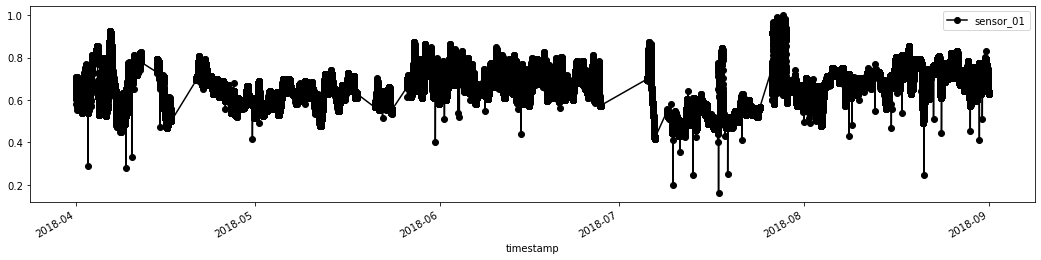

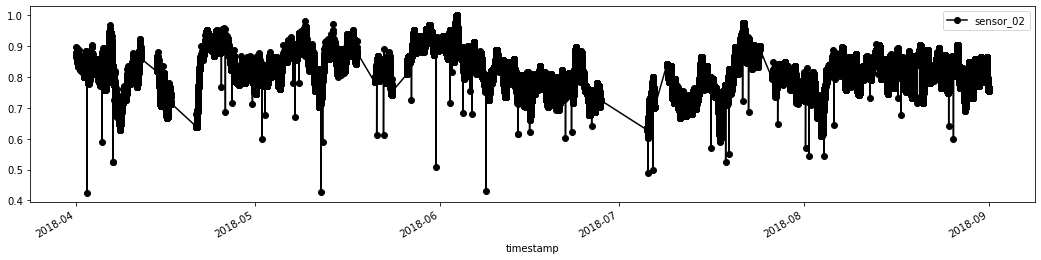

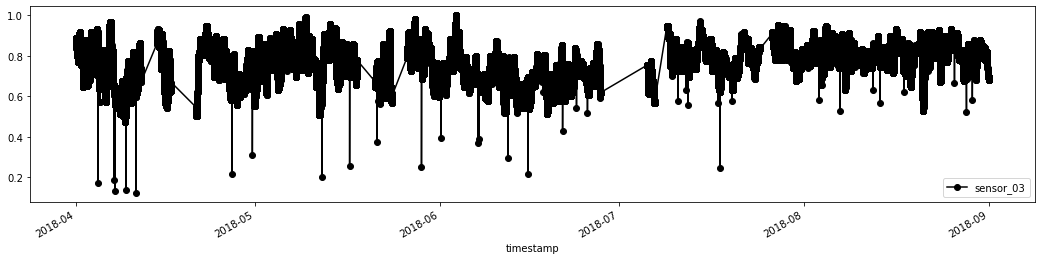

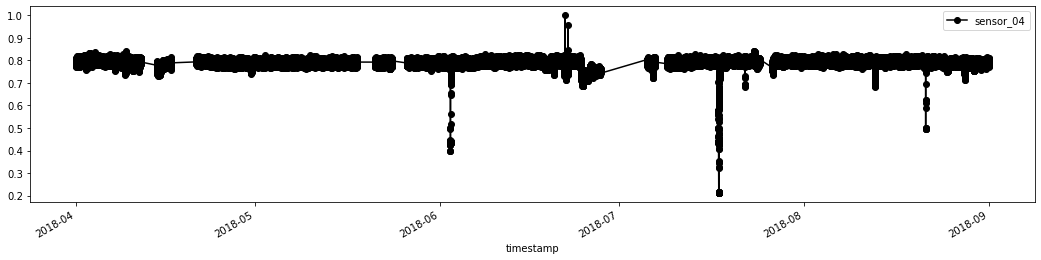

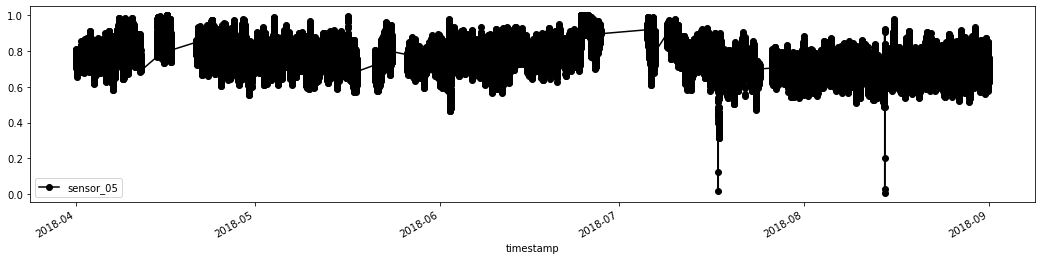

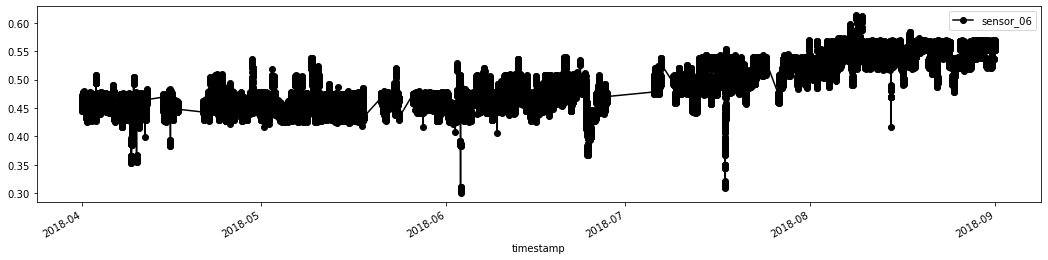

In [23]:
# Check the results of row removal
df_norm = df_norm.loc[:,include_cols] 
for sen in df_norm.columns[1:-1]:
    df_norm[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

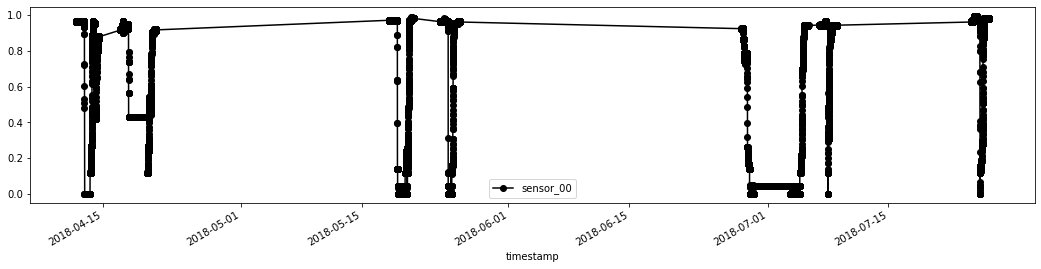

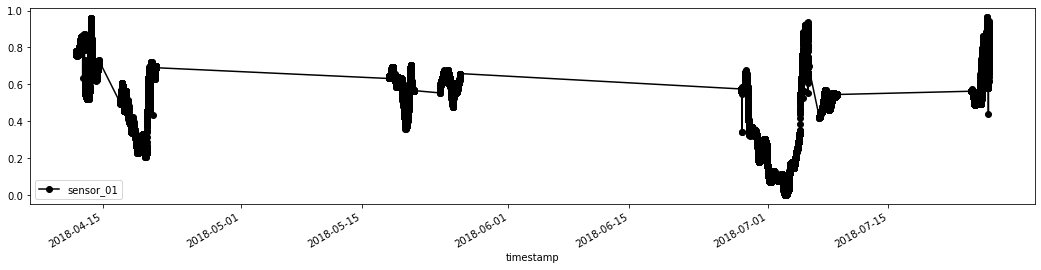

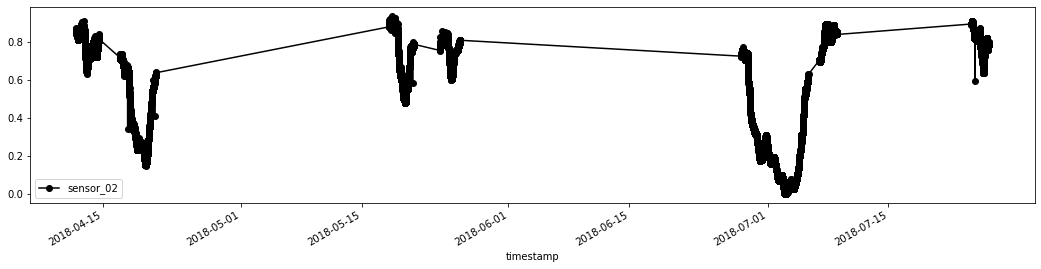

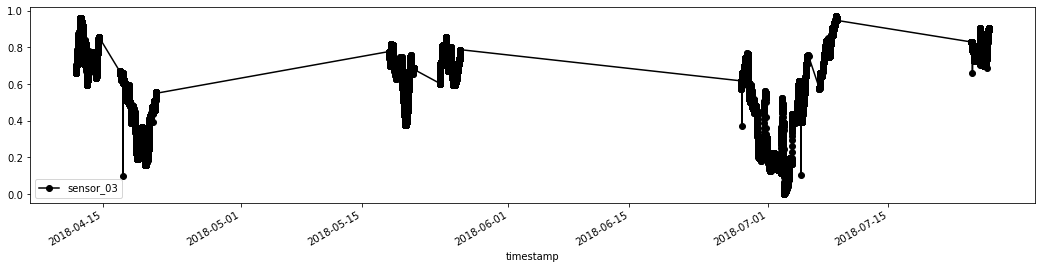

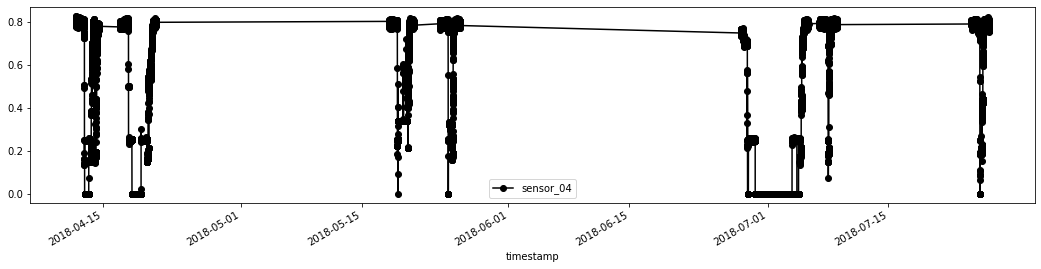

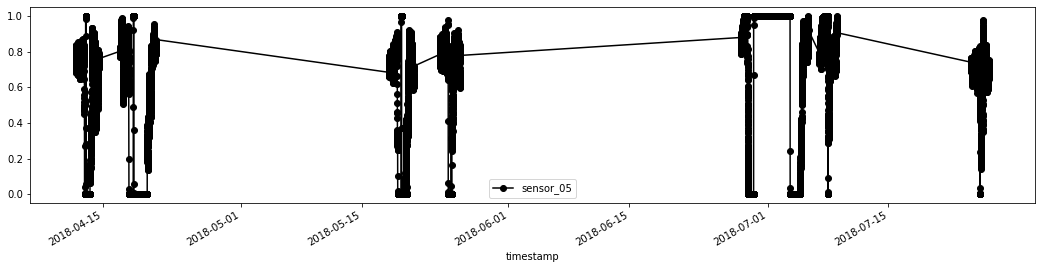

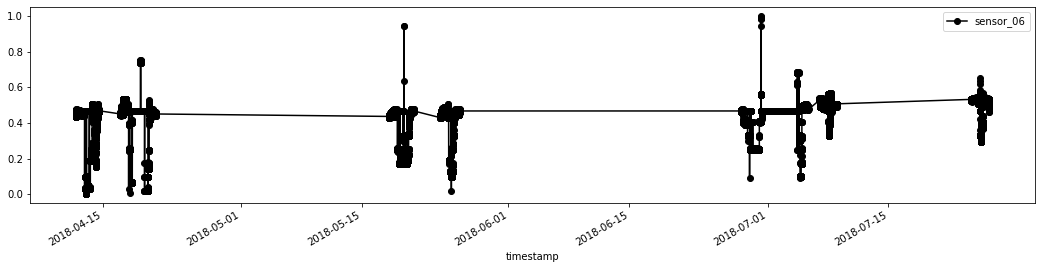

In [25]:
# Check the results of row removal
df_abnorm = df_abnorm.loc[:,include_cols] 
for sen in df_abnorm.columns[1:-1]:
    df_abnorm[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

In [27]:
# Create a timestamp column
df_norm['timestamp'] = pd.to_datetime(df_norm.index, format = '%Y-%m-%d %H:%M:%S')
df_abnorm['timestamp'] = pd.to_datetime(df_abnorm.index, format = '%Y-%m-%d %H:%M:%S')

In [28]:
# Split abnormal now into its different categories
df_abnorm_lead = df_abnorm.loc[df_abnorm['machine_status'] == 'NORMAL', include_cols] 
print('Test dataset 1', df_abnorm_lead['machine_status'].unique())
df_abnorm_broke = df_abnorm.loc[df_abnorm['machine_status'] == 'BROKEN', include_cols] 
print('Test dataset 2', df_abnorm_broke['machine_status'].unique())
df_abnorm_recover = df_abnorm.loc[df_abnorm['machine_status'] == 'RECOVERING', include_cols] 
print('Test dataset 3', df_abnorm_recover['machine_status'].unique())

Test dataset 1 ['NORMAL']
Test dataset 2 ['BROKEN']
Test dataset 3 ['RECOVERING']


In [29]:
# Prepare data for PCA
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)  

In [29]:
print(df_train.columns)

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06'],
      dtype='object')


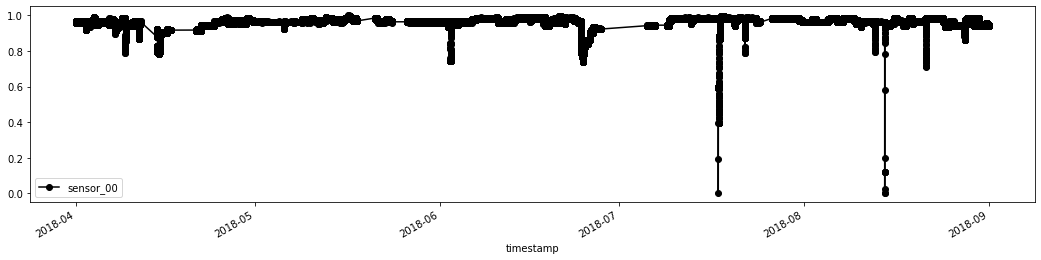

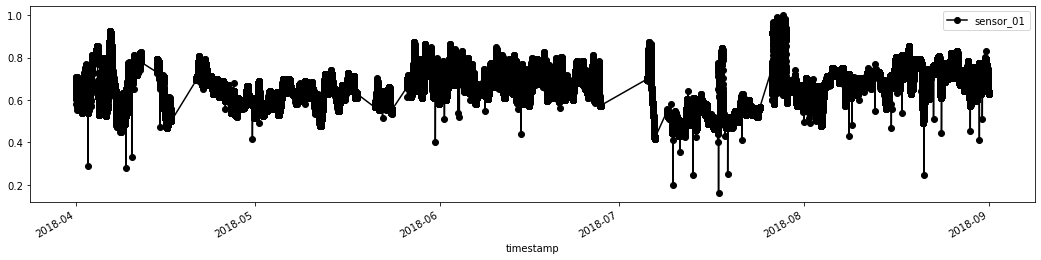

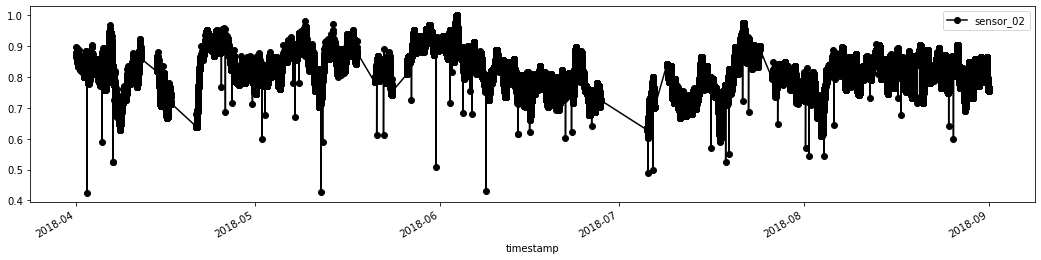

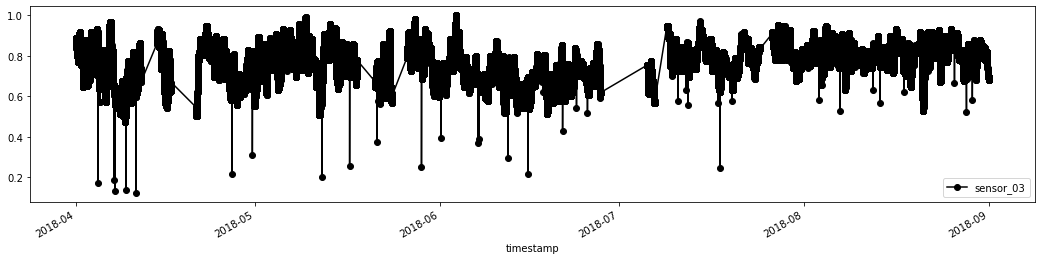

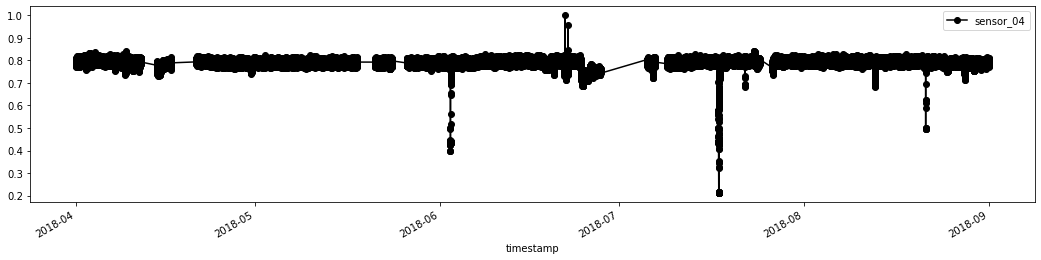

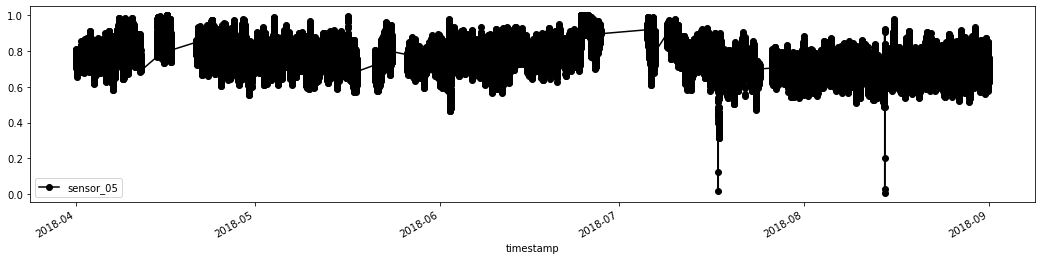

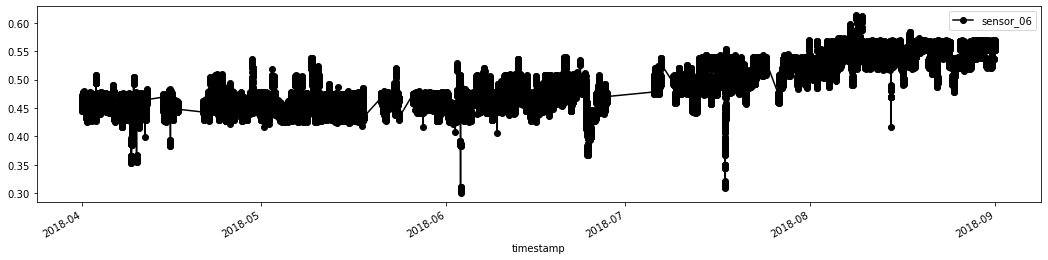

In [30]:
# Check the results of row removal
for sen in df_train.columns:
    df_train[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

### Principle Component Analysis (PCA)

In [31]:
# Define the PCA model (all compoments)
n_comps = 2 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Project the test data onto the PCA space
X_test2_PCA = pca.transform(df_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

# Project the test data onto the PCA space
X_test3_PCA = pca.transform(df_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.437 0.213]


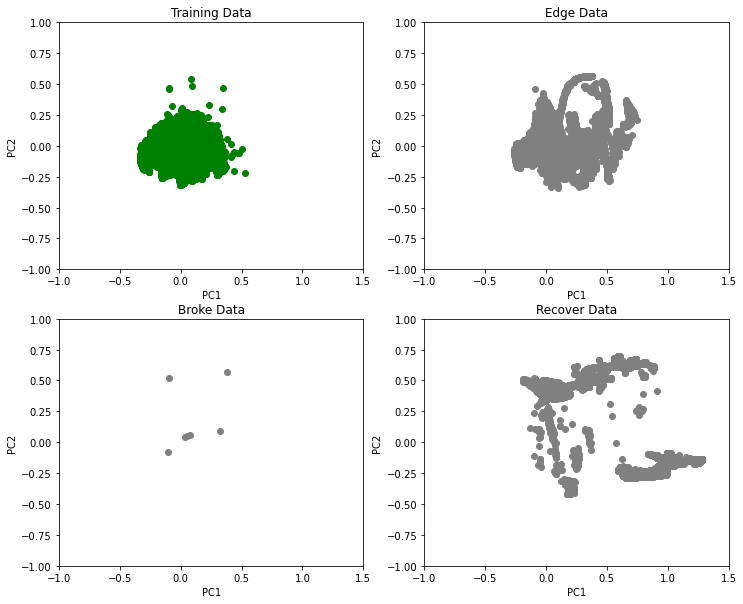

In [32]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 1.5)
ax0.set_ylim(-1, 1)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 1.5)
ax1.set_ylim(-1, 1)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-1, 1.5)
ax2.set_ylim(-1, 1)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-1, 1.5)
ax3.set_ylim(-1, 1)
ax3.set_title('Recover Data')

plt.show()

In [33]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [5.909e-17 5.909e-17]
Minimum & maximum MD in training set: 0.004675794439548307 6.913924174552735
Minimum & maximum MD in test set 1  : 0.0017588812406509268 7.9318717479533145
Minimum & maximum MD in test set 2  : 0.6508776639792797 7.928952850525483
Minimum & maximum MD in test set 3  : 0.5789546985026571 11.545358797487486
Threshold value for flagging an anomaly is 3.77


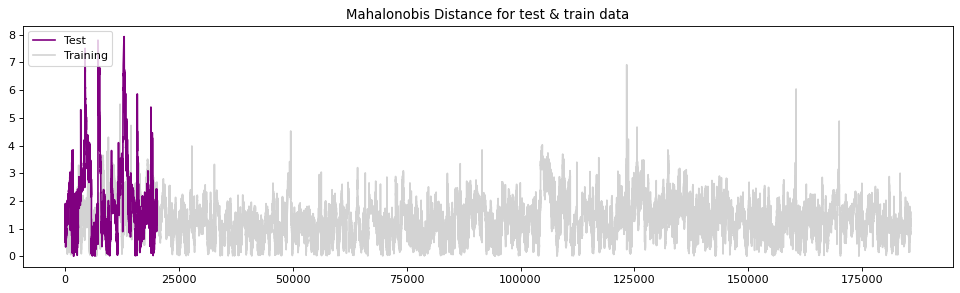

In [34]:
figure(figsize = (15, 4), dpi = 80)
plt.plot(np.array(dist_test1), label = "Test", color = 'purple', zorder = 2)
plt.plot(np.array(dist_train) , label = "Training", color = 'lightgrey', zorder = 1)
plt.legend(loc = "upper left")
plt.title("Mahalonobis Distance for test & train data")
plt.show()

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


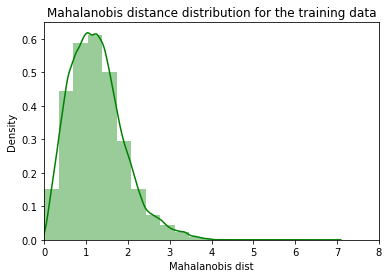

In [35]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde = True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [131]:
def prep_mahalonobis_data (dist_dat, thresh, pca_dat):
    # Prepare test data for visualization
    dat = pd.DataFrame()
    dat['Mob dist'] = dist_dat
    dat['Thresh'] = thresh
    dat['Anomaly'] = dat['Mob dist'] > dat['Thresh']
    dat.index = pca_dat.index
    dat['timestamp'] = dat.index

    n_outliers = dat[dat['Anomaly'] == True].shape[0]
    print("There are", n_outliers, "anomalies in the test set out of", dat.shape[0], "points")
    print("Corresponding to " + str(round(100*(n_outliers / dat.shape[0]), 2)) + '%')

    return(dat)

In [37]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = pdm.prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = pdm.prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 166 anomalies in the test set out of 185676 points
> Corresponding to 0.09%
There are 1864 anomalies in the test set out of 20160 points
> Corresponding to 9.25%
There are 2 anomalies in the test set out of 7 points
> Corresponding to 28.57%
There are 14251 anomalies in the test set out of 14477 points
> Corresponding to 98.44%


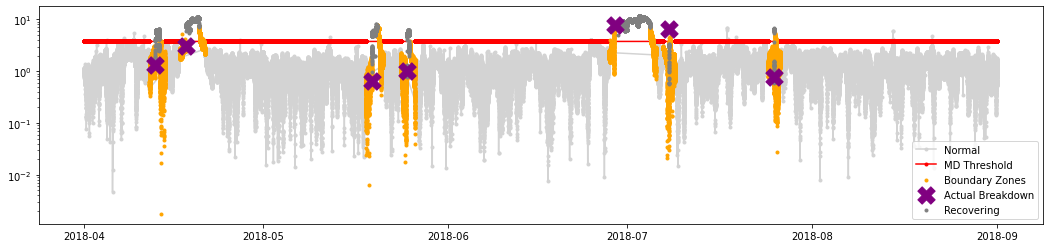

In [38]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

### Robust Principle Component Analysis (R-PCA)

In [39]:
# Prepare data for PCA
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

# Compute all PCA components for the training set
L_train, S_train = pdm.R_pca(df_train).fit()
X_train_PCA = pca.fit_transform(L_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
L_test1, S_test1 = pdm.R_pca(df_test1).fit()
X_test1_PCA = pca.transform(L_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

L_test2, S_test2 = pdm.R_pca(df_test2).fit()
X_test2_PCA = pca.transform(L_test2)
X_test2_PCA = pd.DataFrame(X_test2_PCA)
X_test2_PCA.index = df_test2.index

L_test3, S_test3 = pdm.R_pca(df_test3).fit()
X_test3_PCA = pca.transform(L_test3)
X_test3_PCA = pd.DataFrame(X_test3_PCA)
X_test3_PCA.index = df_test3.index

iteration: 1, error: 1.038623242451124
iteration: 100, error: 0.006959014475317882
iteration: 200, error: 0.003982448973976776
iteration: 300, error: 0.002422792389774784
iteration: 400, error: 0.0033831832445396833
iteration: 500, error: 0.001489319554496669
iteration: 600, error: 0.0011355119871216245
iteration: 700, error: 0.0008667102198825708
iteration: 800, error: 0.0005623964322153399
iteration: 900, error: 0.00031618816417210567
iteration: 1000, error: 0.0002481960790112833
iteration: 1, error: 0.8603327082057718
iteration: 100, error: 0.007507367483137707
iteration: 200, error: 0.004620205770398407
iteration: 300, error: 0.0024171769314781945
iteration: 400, error: 0.0016981514762012032
iteration: 500, error: 0.0009472845473848574
iteration: 600, error: 0.0005692926099432385
iteration: 700, error: 0.0002676193817316079
iteration: 800, error: 0.00018749104629941918
iteration: 900, error: 0.00010046159288468967
iteration: 1000, error: 5.874550227088736e-05
iteration: 1, error: 0

In [40]:
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress = True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.864 0.09 ]


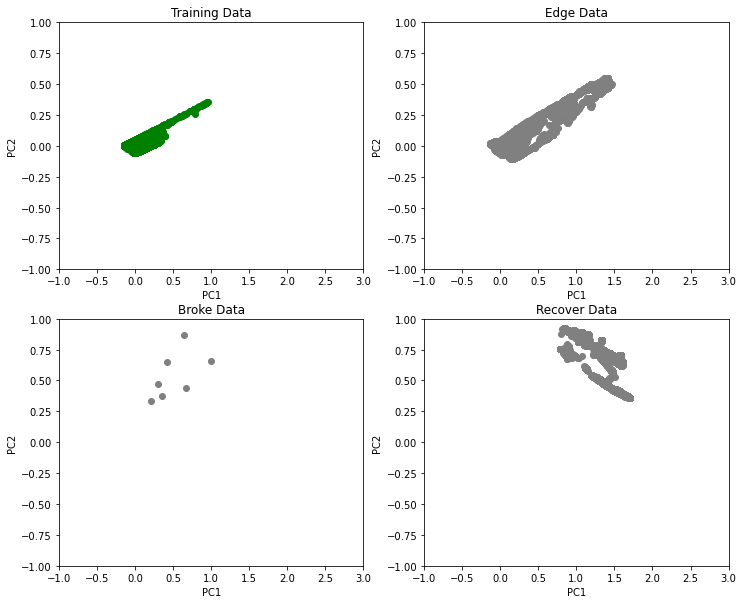

In [41]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-1, 3)
ax0.set_ylim(-1, 1)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-1, 3)
ax1.set_ylim(-1, 1)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_PCA.loc[:, 0], X_test2_PCA.loc[:, 1], color = 'grey')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_xlim(-1, 3)
ax2.set_ylim(-1, 1)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_PCA.loc[:, 0], X_test3_PCA.loc[:, 1], color = 'grey')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_xlim(-1, 3)
ax3.set_ylim(-1, 1)
ax3.set_title('Recover Data')

plt.show()

In [42]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)
data_test2 = np.array(X_test2_PCA.values)
data_test3 = np.array(X_test3_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [1.638e-15 2.744e-14]
Minimum & maximum MD in training set: 0.0070003677003165465 20.420988286826844
Minimum & maximum MD in test set 1  : 0.05693282596336806 31.162622677688336
Minimum & maximum MD in test set 2  : 14.753119301172676 38.85792944637424
Minimum & maximum MD in test set 3  : 27.88258836847665 42.15637330934416
Threshold value for flagging an anomaly is 3.57


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


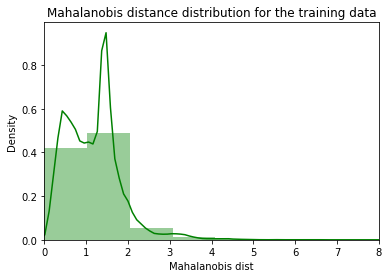

In [43]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [44]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_PCA)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_PCA)

There are 1552 anomalies in the test set out of 185676 points
Corresponding to 0.84%
There are 7125 anomalies in the test set out of 20160 points
Corresponding to 35.34%
There are 7 anomalies in the test set out of 7 points
Corresponding to 100.0%
There are 14477 anomalies in the test set out of 14477 points
Corresponding to 100.0%


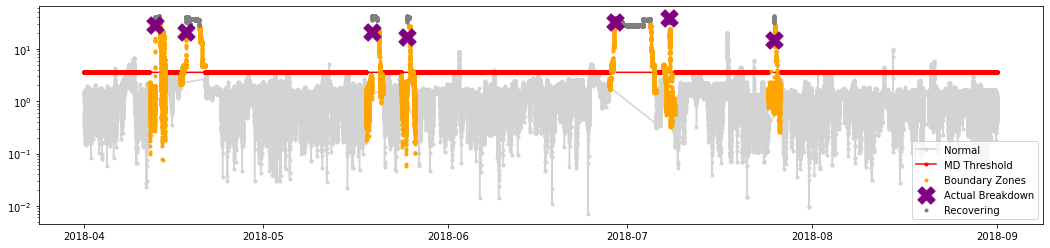

In [53]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
ZOOM = False
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
if ZOOM is True:
    ax.set_xlim(
        pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
        pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    )
ax.legend(loc = 'lower right')
plt.show()

### Uniform Manifold Approximation & Projection (UMAP)
https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [124]:
import umap

In [142]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

# Fit & transform training data using UMAP
reducer = umap.UMAP(n_neighbors = 5, min_dist = 0.1) # 5, 10, 15
X_train_UMAP = reducer.fit_transform(df_train)
print('UMAP embeddings shape', X_train_UMAP.shape)

UMAP embeddings shape (185676, 2)


In [143]:
# Project test data on to the UMAP sapce
X_test1_UMAP = reducer.transform(df_test1)
X_test2_UMAP = reducer.transform(df_test2)
X_test3_UMAP = reducer.transform(df_test3)

/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [144]:
X_train_UMAP = pd.DataFrame(X_train_UMAP)
X_train_UMAP.index = df_train.index

X_test1_UMAP = pd.DataFrame(X_test1_UMAP)
X_test1_UMAP.index = df_test1.index

X_test2_UMAP = pd.DataFrame(X_test2_UMAP)
X_test2_UMAP.index = df_test2.index

X_test3_UMAP = pd.DataFrame(X_test3_UMAP)
X_test3_UMAP.index = df_test3.index

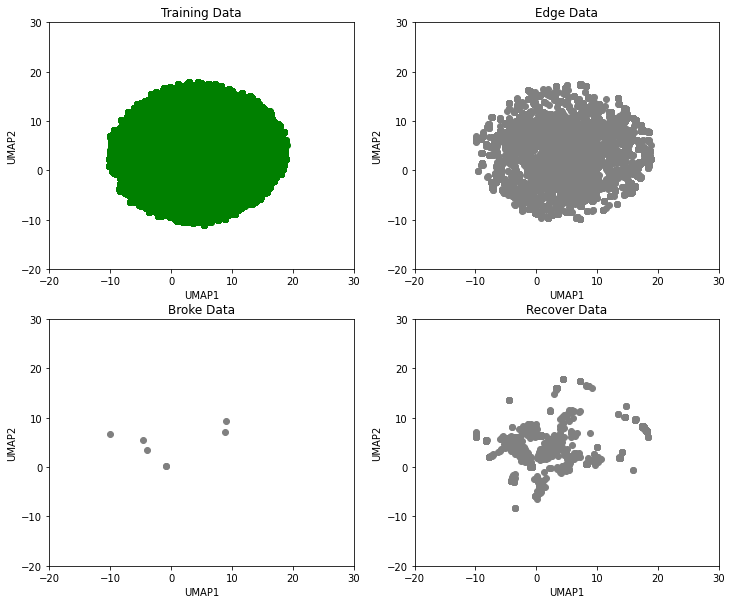

In [145]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_UMAP.loc[:, 0], X_train_UMAP.loc[:, 1], color = 'green')
ax0.set_xlabel('UMAP1')
ax0.set_ylabel('UMAP2')
ax0.set_xlim(-20, 30)
ax0.set_ylim(-20, 30)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_UMAP.loc[:, 0], X_test1_UMAP.loc[:, 1], color = 'grey')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')
ax1.set_xlim(-20, 30)
ax1.set_ylim(-20, 30)
ax1.set_title('Edge Data')

ax2 = plt.subplot(gs[2])
ax2.scatter(X_test2_UMAP.loc[:, 0], X_test2_UMAP.loc[:, 1], color = 'grey')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_xlim(-20, 30)
ax2.set_ylim(-20, 30)
ax2.set_title('Broke Data')

ax3 = plt.subplot(gs[3])
ax3.scatter(X_test3_UMAP.loc[:, 0], X_test3_UMAP.loc[:, 1], color = 'grey')
ax3.set_xlabel('UMAP1')
ax3.set_ylabel('UMAP2')
ax3.set_xlim(-20, 30)
ax3.set_ylim(-20, 30)
ax3.set_title('Recover Data')

plt.show()

In [146]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_UMAP)
data_test1 = np.array(X_test1_UMAP)
data_test2 = np.array(X_test2_UMAP)
data_test3 = np.array(X_test3_UMAP)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_test2 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test2, verbose=False)
dist_test3 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test3, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))
print("Minimum & maximum MD in test set 2  :", min(dist_test2), max(dist_test2))
print("Minimum & maximum MD in test set 3  :", min(dist_test3), max(dist_test3))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [4.317 3.733]
Minimum & maximum MD in training set: 0.012107974443935125 2.5392162491766745
Minimum & maximum MD in test set 1  : 0.003218680930985535 2.440280447598868
Minimum & maximum MD in test set 2  : 0.9210007020191656 2.432460361183637
Minimum & maximum MD in test set 3  : 0.04941960494089445 2.4425338415808704
Threshold value for flagging an anomaly is 3.89


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


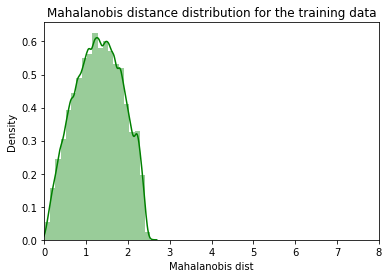

In [147]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 20, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [148]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = prep_mahalonobis_data(dist_train, threshold, X_train_UMAP)
anomaly1 = prep_mahalonobis_data(dist_test1, threshold, X_test1_UMAP)
anomaly2 = prep_mahalonobis_data(dist_test2, threshold, X_test2_UMAP)
anomaly3 = prep_mahalonobis_data(dist_test3, threshold, X_test3_UMAP)

There are 0 anomalies in the test set out of 185676 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 20160 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 7 points
Corresponding to 0.0%
There are 0 anomalies in the test set out of 14477 points
Corresponding to 0.0%


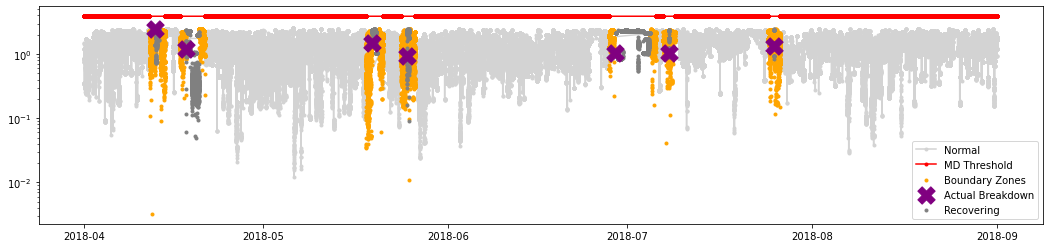

In [149]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
ZOOM = False
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot(anomaly_train['timestamp'], anomaly_train['Thresh'], color = 'red', marker = '.', zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.scatter(anomaly2['timestamp'], anomaly2['Mob dist'], color = 'purple', marker = 'X', zorder = 5, s = 300, label = 'Actual Breakdown')
ax.scatter(anomaly3['timestamp'], anomaly3['Mob dist'], color = 'grey', marker = '.', zorder = 4, label = 'Recovering')
ax.set_yscale('log')
if ZOOM is True:
    ax.set_xlim(
        pd.to_datetime('2018-04-10 00:00:00', format = '%Y-%m-%d %H:%M:%S'), 
        pd.to_datetime('2018-04-20 00:00:00', format = '%Y-%m-%d %H:%M:%S')
    )
ax.legend(loc = 'lower right')
plt.show()

### One-class Support Vector Machine (SVM)

In [48]:
from sklearn.svm import OneClassSVM

In [49]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [50]:
# Train a one-class SVM 
# nu = contamination 
svm_model =  OneClassSVM(nu = 0.01) 
svm_model.fit(pd.DataFrame(df_train))

OneClassSVM(nu=0.01)

In [51]:
# Predict for train set (normal operating)
preds = pd.Series(svm_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly0 = svm_aly

1856 out of 185676 (1.0%)


In [52]:
# Predict for test set 1 (boundary segments)
preds = pd.Series(svm_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly1 = svm_aly

5946 out of 20160 (29.49%)


In [53]:
# Predict for test set 2 (breakdown points)
preds = pd.Series(svm_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly2 = svm_aly

6 out of 7 (85.71%)


In [54]:
# Predict for test set 3 (recovery points)
preds = pd.Series(svm_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
svm_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
svm_out['sensor_04'] = sensor_04
svm_out['Prediction'] = svm_out['Prediction'].map({1: 0, -1: 1})
svm_aly = svm_out.loc[svm_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(svm_aly)) + ' out of ' + str(len(svm_out)) + ' (' + str(round(100 * (len(svm_aly) / len(svm_out)), 2)) + '%)')
svm_aly3 = svm_aly

14477 out of 14477 (100.0%)


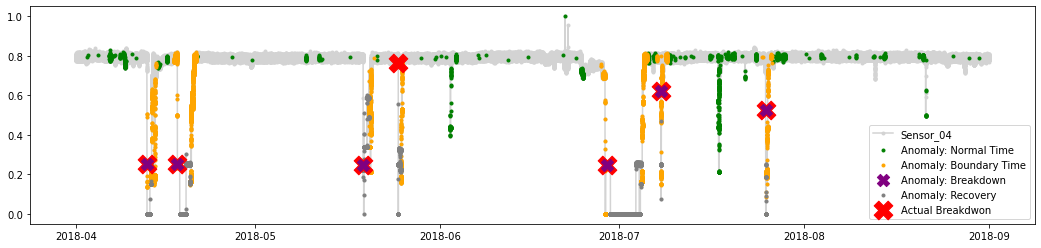

In [55]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(svm_aly0['timestamp'], svm_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.scatter(svm_aly1['timestamp'], svm_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(svm_aly2['timestamp'], svm_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
ax.scatter(svm_aly3['timestamp'], svm_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()

### Isolation Forest

Overview of Isolation forest steps:
https://ieeexplore.ieee.org/abstract/document/4781136
1. Build trees,
2. Pass each data point through each tree,
3. Calculate the average path that is required to isolate the point.
4. The shorter the path, the higher the anomaly score.

In [56]:
from sklearn.ensemble import IsolationForest

In [57]:
# Prepare data for dimensional reduction
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)

In [58]:
# Train isolation forest 
isfo_model =  IsolationForest(contamination = 0.01)
isfo_model.fit(df_train)

IsolationForest(contamination=0.01)

In [59]:
# Predict for train set (normal operating)
preds = pd.Series(isfo_model.predict(df_train))
test = pd.DataFrame({'sensor_04':pd.Series(df_train['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_train.index, 'Prediction':preds})
sensor_04 = df_train['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly0 = isfo_aly

1857 out of 185676 (1.0%)


In [60]:
# Predict for test set 1 ()
preds = pd.Series(isfo_model.predict(df_test1))
test = pd.DataFrame({'sensor_04':pd.Series(df_test1['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test1.index, 'Prediction':preds})
sensor_04 = df_test1['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly1 = isfo_aly

4734 out of 20160 (23.48%)


In [61]:
# Predict for test set 2 ()
preds = pd.Series(isfo_model.predict(df_test2))
test = pd.DataFrame({'sensor_04':pd.Series(df_test2['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test2.index, 'Prediction':preds})
sensor_04 = df_test2['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly2 = isfo_aly

4 out of 7 (57.14%)


In [62]:
# Predict for test set 3 ()
preds = pd.Series(isfo_model.predict(df_test3))
test = pd.DataFrame({'sensor_04':pd.Series(df_test3['sensor_04'])})
isfo_out = pd.DataFrame({'timestamp':df_test3.index, 'Prediction':preds})
sensor_04 = df_test3['sensor_04']
sensor_04 = sensor_04.reset_index()
sensor_04.drop('timestamp', axis = 1, inplace = True)
isfo_out['sensor_04'] = sensor_04
isfo_out['Prediction'] = isfo_out['Prediction'].map({1: 0, -1: 1})
isfo_aly = isfo_out.loc[isfo_out['Prediction'] == 1, ['timestamp', 'sensor_04']] # anomaly
print(str(len(isfo_aly)) + ' out of ' + str(len(isfo_out)) + ' (' + str(round(100 * (len(isfo_aly) / len(isfo_out)), 2)) + '%)')
isfo_aly3 = isfo_aly

14468 out of 14477 (99.94%)


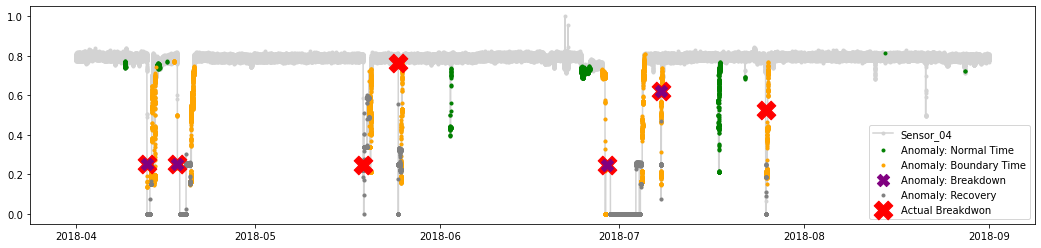

In [63]:
# Visualize machine status over time for the data using sensor04 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['timestamp'], df_set_scaled['sensor_04'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Sensor_04')
ax.scatter(isfo_aly0['timestamp'], isfo_aly0['sensor_04'], color ='green', marker = '.', zorder = 2, label = 'Anomaly: Normal Time')
ax.scatter(isfo_aly1['timestamp'], isfo_aly1['sensor_04'], color ='orange', marker = '.', zorder = 2, label = 'Anomaly: Boundary Time')
ax.scatter(isfo_aly2['timestamp'], isfo_aly2['sensor_04'], color ='purple', marker = 'X', s = 150, zorder = 5, label = 'Anomaly: Breakdown')
ax.scatter(isfo_aly3['timestamp'], isfo_aly3['sensor_04'], color ='grey', marker = '.', zorder = 3, label = 'Anomaly: Recovery')
ax.scatter(df_abnorm_broke['timestamp'], df_abnorm_broke['sensor_04'], color = 'red', marker = 'X', zorder = 4, s = 350, label = 'Actual Breakdwon')
ax.legend(loc = 'lower right')
plt.show()

### LSTM

RNN learn to recognize sequence in the data and then make prediction based on the previous sequence. We consider an anomaly when the next data points are distant from RNN prediction. Aggregation, size of sequence and size of prediction for anomaly are important parameters to have relevant detection.
Here we make learn from 50 previous values, and we predict just the 1 next value.

In [ ]:
data_n = df_set_scaled.drop(['timestep', 'machine_status]', axis = 1)

# important parameters and train/test size
prediction_time = 1 
testdatasize = 700
unroll_length = 50 # consider n last datapoints (this will be sequence length)
testdatacut = testdatasize + unroll_length  + 1

pred_chan = 'sensor_04'

# train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut][pred_chan].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:][pred_chan].values

# See the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
#unroll: create sequence of 50 previous data points for each data point
def unroll(data, sequence_length = 24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# Adapt the datasets for the sequence data shape
x_train = unroll(x_train, unroll_length)
x_test  = unroll(x_test, unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# See the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

In [ ]:
# Load libraries for RNN
# Keras acts as an interface for the TensorFlow library
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

In [ ]:
# Build the model
lstm_model = Sequential()

In [ ]:
lstm_model.add(LSTM(
    #input_shape = x_train.shape[-1],
    return_sequences = True,
    units = 50))

In [ ]:
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(100, return_sequences = False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.add(Activation('linear'))

start = time.time()
lstm_model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

In [ ]:
# Train the model

# Some notes on hyperparameters:
# ==============================
# Batch Size: Hyperparameter of gradient descent that controls the no. of 
# training samples to work through before the model’s internal parameters are updated.

"""
- Batch Gradient Descent: Batch Size = Size of Training Set
- Stochastic Gradient Descent: Batch Size = 1
- Mini-Batch Gradient Descent: 1 < Batch Size < Size of Training Set
In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples.
"""

# Epochs: Hyperparameter of gradient descent that controls the number of complete 
# passes through the training dataset.

lstm_model.fit(
    x_train,
    y_train,
    batch_size = 3028, # TODO -- Update
    epochs = 30,
    validation_split = 0.1)

In [ ]:
# Create the list of difference between prediction and test data
loaded_model = lstm_model
diff = []
ratio = []
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

In [ ]:
# plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(p, color = 'red', label = 'prediction')
axs.plot(y_test, color = 'grey', label = 'actual')
plt.legend(loc = 'upper left')
plt.show()

### LSTM Autoencoder

In [34]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [35]:
# set random seed
seed(13)
tf.random.set_seed(13)

In [81]:
# Refresh the data
df_train = df_norm.loc[:, include_cols]  
df_train = df_train.drop(['machine_status', 'timestamp'], axis = 1)    
df_train_df = df_train
df_train = df_train.to_numpy()

df_test1 = df_abnorm_lead.loc[:, include_cols]
df_test1 = df_test1.drop(['machine_status', 'timestamp'], axis = 1)  
df_test1_df = df_test1
df_test1 = df_test1.to_numpy()

df_test2 = df_abnorm_broke.loc[:, include_cols]
df_test2 = df_test2.drop(['machine_status', 'timestamp'], axis = 1)  
df_test2_df = df_test2
df_test2 = df_test2.to_numpy()

df_test3 = df_abnorm_recover.loc[:, include_cols]
df_test3 = df_test3.drop(['machine_status', 'timestamp'], axis = 1)
df_test3_df = df_test3
df_test3 = df_test3.to_numpy()

In [83]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_train = df_train.reshape(df_train.shape[0], 1, df_train.shape[1])
print("Training data shape:", X_train.shape)

X_test1 = df_test1.reshape(df_test1.shape[0], 1, df_test1.shape[1])
print("Test data 1 shape:", X_test1.shape)

X_test2 = df_test2.reshape(df_test2.shape[0], 1, df_test2.shape[1])
print("Test data 2 shape:", X_test2.shape)

X_test3 = df_test3.reshape(df_test3.shape[0], 1, df_test3.shape[1])
print("Test data 3 shape:", X_test3.shape)

Training data shape: (185676, 1, 7)
Test data 1 shape: (20160, 1, 7)
Test data 2 shape: (7, 1, 7)
Test data 3 shape: (14477, 1, 7)


In [38]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [39]:
# Create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1536      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 7)             

In [65]:
# Fit the model to the data
nb_epochs = 80
batch_size = 1000
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0445
Epoch 2/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0447 - val_loss: 0.0445
Epoch 3/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0447 - val_loss: 0.0446
Epoch 4/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0447 - val_loss: 0.0446
Epoch 5/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0447 - val_loss: 0.0446
Epoch 6/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0447 - val_loss: 0.0445
Epoch 7/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0445
Epoch 8/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0445
Epoch 9/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0445
Epoch 10/80
177/177 [==============================] - 1s 5ms/step - loss: 0.0448 - val_loss: 0.0446

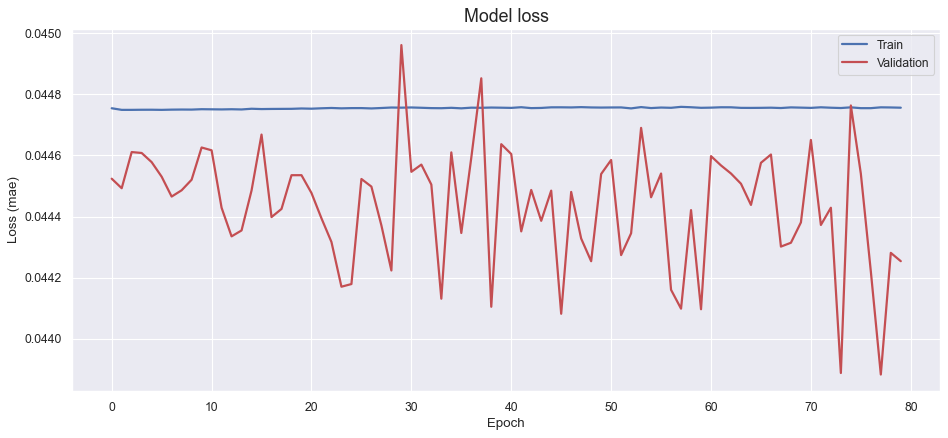

In [66]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

C:\Users\jpayn\anaconda3\envs\pdm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

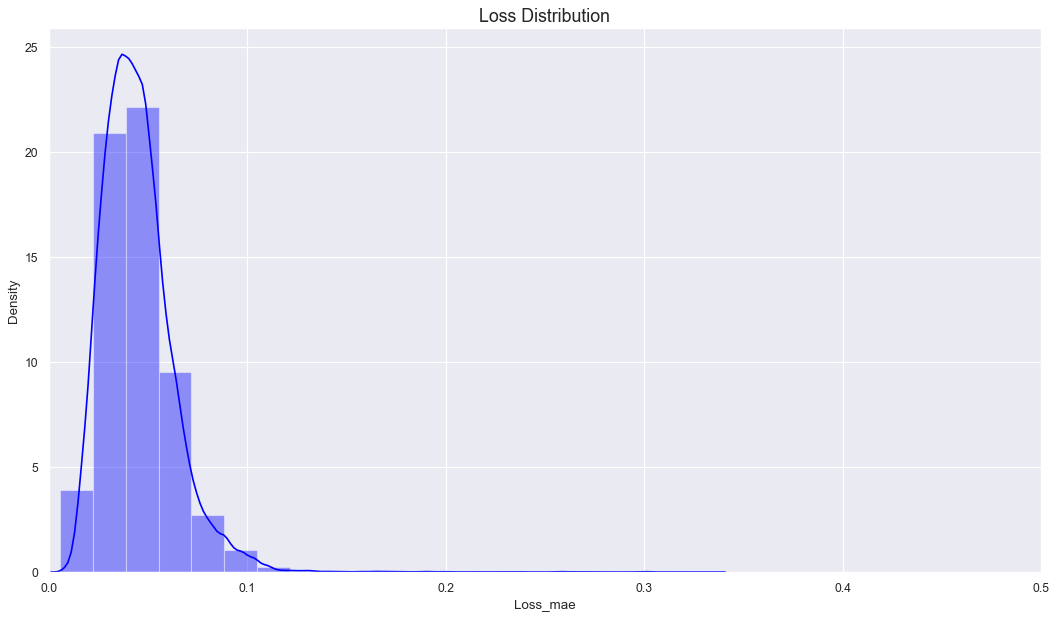

In [67]:
# Plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train_df.columns)
X_pred.index = df_train_df.index

scored = pd.DataFrame(index=df_train_df.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0, 0.5])

In [94]:
def calc_test_loss(test, test_df, thresh):
    # Calculate the loss on the test set 1
    X_pred = model.predict(test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test_df.columns)
    X_pred.index = test_df.index

    scored = pd.DataFrame(index=test_df.index)
    Xtest = test.reshape(test.shape[0], test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred - Xtest), axis=1)
    scored['Threshold'] = thresh
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    print(scored.head())
    return(scored)

In [95]:
# Calculate the loss on the test set 1
selected_threshold = 0.12
scored1 = calc_test_loss(X_test1, df_test1_df, selected_threshold)
scored2 = calc_test_loss(X_test2, df_test2_df, selected_threshold)
scored3 = calc_test_loss(X_test3, df_test3_df, selected_threshold)

                     Loss_mae  Threshold  Anomaly
timestamp                                        
2018-04-11 21:55:00  0.050173       0.12    False
2018-04-11 21:56:00  0.046617       0.12    False
2018-04-11 21:57:00  0.047792       0.12    False
2018-04-11 21:58:00  0.047828       0.12    False
2018-04-11 21:59:00  0.047840       0.12    False
                     Loss_mae  Threshold  Anomaly
timestamp                                        
2018-04-12 21:55:00  0.296126       0.12     True
2018-04-18 00:30:00  0.272000       0.12     True
2018-05-19 03:18:00  0.122824       0.12     True
2018-05-25 00:30:00  0.048061       0.12    False
2018-06-28 22:00:00  0.448366       0.12     True
                     Loss_mae  Threshold  Anomaly
timestamp                                        
2018-04-12 21:56:00  0.291083       0.12     True
2018-04-12 21:57:00  0.347056       0.12     True
2018-04-12 21:58:00  0.334096       0.12     True
2018-04-12 21:59:00  0.342292       0.12     True


In [96]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train_df.columns)
X_pred_train.index = df_train_df.index

scored_train = pd.DataFrame(index=df_train_df.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.12
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

scored = pd.concat([scored_train, scored1, scored2, scored3])
scored.head()

,Loss_mae,Threshold,Anomaly
timestamp,,,
2018-04-01 00:00:00,0.035877,0.12,False
2018-04-01 00:01:00,0.035877,0.12,False
2018-04-01 00:02:00,0.039221,0.12,False
2018-04-01 00:03:00,0.038441,0.12,False
2018-04-01 00:04:00,0.037766,0.12,False


<AxesSubplot:xlabel='timestamp'>

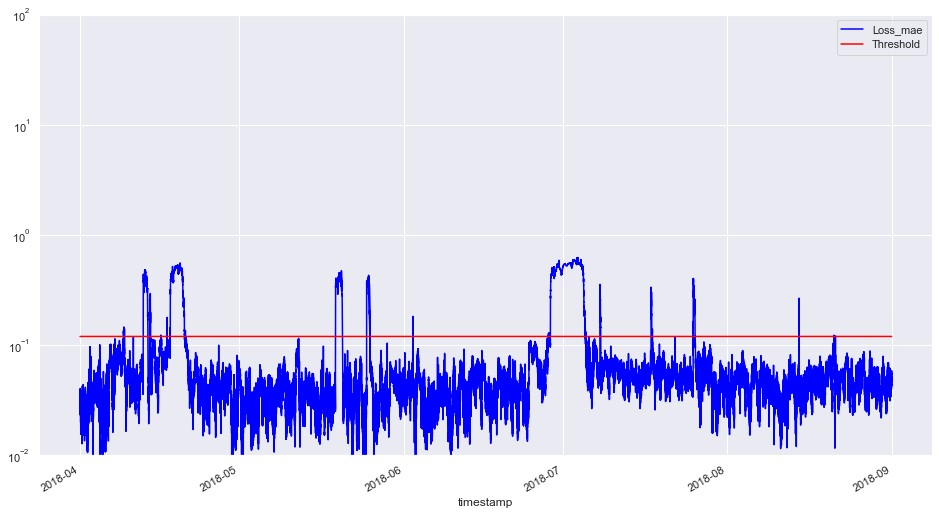

In [97]:
# plot bearing failure time plot
scored.plot(logy = True,  figsize=(16, 9), ylim=[1e-2, 1e2], color=['blue','red'])

In [61]:
scored['Threshold'].unique()

array([0.12 , 0.275])

In [ ]:
# Save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")